In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [310]:
df = pd.read_csv('./output.csv')

In [311]:
df.head()

,Product,City,Date,Index Value,% Change
0,Lamb and goat,Sydney,1948-09-01,NaN,NaN
1,Lamb and goat,Melbourne,1948-09-01,NaN,NaN
2,Lamb and goat,Brisbane,1948-09-01,NaN,NaN
3,Lamb and goat,Adelaide,1948-09-01,NaN,NaN
4,Lamb and goat,Perth,1948-09-01,NaN,NaN


In [312]:
df = df[df['Product'] == 'Fruit']
df = df.groupby(['Date'])['Index Value'].mean().reset_index()
df




,Date,Index Value
0,1948-09-01,NaN
1,1948-12-01,NaN
2,1949-03-01,NaN
3,1949-06-01,NaN
4,1949-09-01,NaN
...,...,...
294,2022-03-01,100.755556
295,2022-06-01,104.744444
296,2022-09-01,111.688889
297,2022-12-01,108.288889


In [313]:
df = df.sort_values(by='Date')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df[df['Index Value'].notna()]



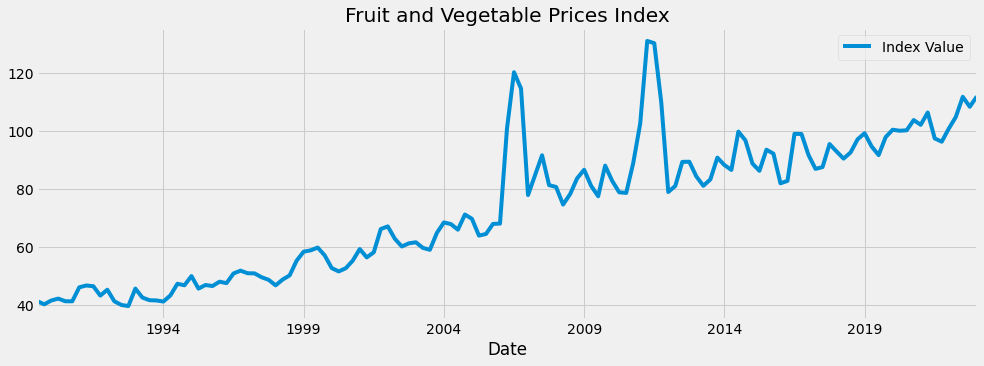

In [314]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Fruit and Vegetable Prices Index')
plt.show()

In [315]:
train = df.loc[df.index < '01-01-2014']
test = df.loc[df.index >= '01-01-2014']

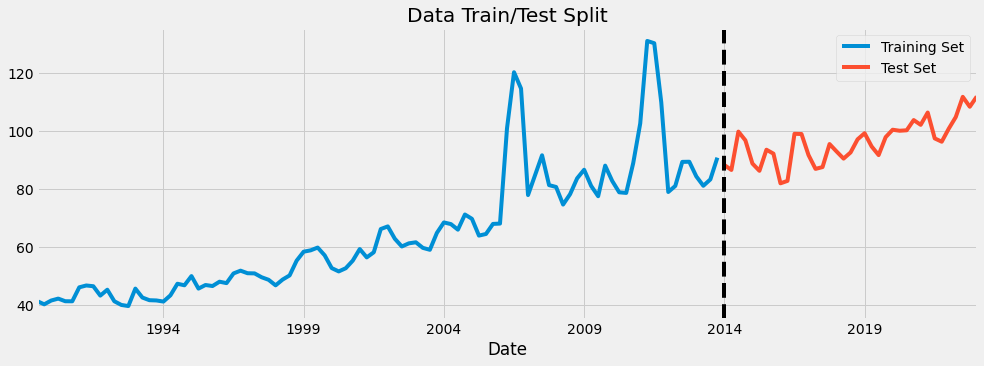

In [316]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2014', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [317]:

def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df1 = pd.get_dummies(df, columns=['quarter'], prefix=['quarter'])
    df1['quarter'] = df.index.quarter
    return df1
df = create_features(df)

In [318]:
df

,Index Value,year,quarter_1,quarter_2,quarter_3,quarter_4,quarter
Date,,,,,,,
1989-09-01,41.500000,1989,0,0,1,0,3
1989-12-01,40.388889,1989,0,0,0,1,4
1990-03-01,41.700000,1990,1,0,0,0,1
1990-06-01,42.355556,1990,0,1,0,0,2
1990-09-01,41.455556,1990,0,0,1,0,3
...,...,...,...,...,...,...,...
2022-03-01,100.755556,2022,1,0,0,0,1
2022-06-01,104.744444,2022,0,1,0,0,2
2022-09-01,111.688889,2022,0,0,1,0,3


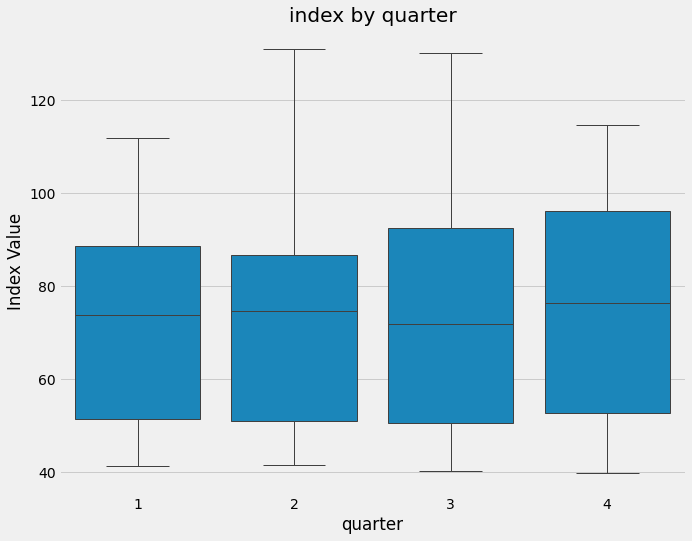

In [319]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='Index Value')
ax.set_title('index by quarter')
plt.show()

In [320]:
train = create_features(train)
test = create_features(test)

FEATURES = ['year', 'quarter_1','quarter_2','quarter_3','quarter_4']	
TARGET = 'Index Value'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [321]:
model = LinearRegression()
model.fit(X_train, y_train)
test['prediction'] = model.predict(X_test)

In [322]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df

,Index Value,year,quarter_1,quarter_2,quarter_3,quarter_4,quarter,prediction
Date,,,,,,,,
1989-09-01,41.500000,1989,0,0,1,0,3,NaN
1989-12-01,40.388889,1989,0,0,0,1,4,NaN
1990-03-01,41.700000,1990,1,0,0,0,1,NaN
1990-06-01,42.355556,1990,0,1,0,0,2,NaN
1990-09-01,41.455556,1990,0,0,1,0,3,NaN
...,...,...,...,...,...,...,...,...
2022-03-01,100.755556,2022,1,0,0,0,1,115.559582
2022-06-01,104.744444,2022,0,1,0,0,2,116.756341
2022-09-01,111.688889,2022,0,0,1,0,3,118.721119


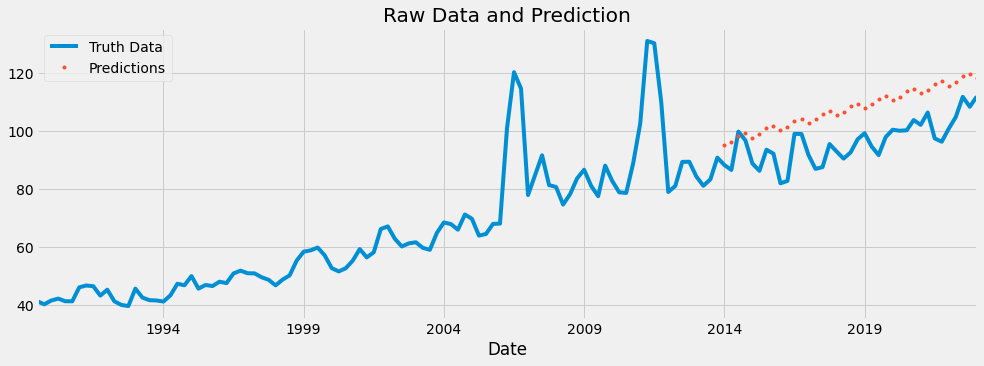

In [323]:

ax = df[['Index Value']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [324]:
coefficients = model.coef_
print("Coefficient for Quarter 1:", coefficients[0])
print("Coefficient for Quarter 2:", coefficients[1])
print("Coefficient for Quarter 3:", coefficients[2])
print("Coefficient for Year:", coefficients[3])

Coefficient for Quarter 1: 2.554148526077097
Coefficient for Quarter 2: -2.0839584278155705
Coefficient for Quarter 3: -0.8871991685563105
Coefficient for Year: 1.0775787981859424
